In [11]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from pandas import set_option
# set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None



##### import stuff from scikit learn
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

filename = 'data/facies_vectors.csv'
training_data = pd.read_csv(filename)

print (training_data.shape)
training_data.head()

(4149, 11)


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [2]:
training_data.dropna(inplace=True)
print (training_data.shape)

(3232, 11)


In [3]:
def make_moving_av_vars(wells_df,logs,windows):
    
    new_df = pd.DataFrame()
    grouped = wells_df.groupby(['Well Name'])

    for key in grouped.groups.keys():

        temp_df = pd.DataFrame()
        temp_df['Depth'] = grouped.get_group(key)['Depth']
        
        for log in logs:

            temp_data = grouped.get_group(key)[log]
            
            for window in windows:
                temp_df[log + '_moving_av_' + str(window) + 'ft'] = pd.rolling_mean(arg=temp_data, window=window, min_periods=1, center=True)                
                
        temp_df['Well Name'] = [key for _ in range(len(temp_df['Depth']))]
        new_df = new_df.append(temp_df) 

        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth', 'NM_M', 'RELPOS']]
    return pd.concat([wells_df,new_df],axis=1)

In [4]:
##### From moving average
moving_av_df = make_moving_av_vars(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                                   windows=[5])
print (moving_av_df.shape)
moving_av_df.head(5)

(3232, 11)


,Facies,Formation,Well Name,Depth,NM_M,RELPOS,GR_moving_av_5ft,ILD_log10_moving_av_5ft,DeltaPHI_moving_av_5ft,PE_moving_av_5ft,PHIND_moving_av_5ft
0,3,A1 SH,SHRIMPLIN,2793.0,1,1.000,78.253333,0.6610,12.966667,4.10,12.51000
1,3,A1 SH,SHRIMPLIN,2793.5,1,0.979,80.215000,0.6595,13.200000,3.95,12.66125
2,3,A1 SH,SHRIMPLIN,2794.0,1,0.957,79.088000,0.6570,13.260000,3.84,12.78900
3,3,A1 SH,SHRIMPLIN,2794.5,1,0.936,78.392000,0.6514,14.080000,3.64,13.08300
4,3,A1 SH,SHRIMPLIN,2795.0,1,0.915,77.484000,0.6452,14.360000,3.56,13.35600


In [5]:
###### create predictor and target arrays
X = moving_av_df.iloc[:, 4:]
y = moving_av_df['Facies']
groups = moving_av_df['Well Name']

In [6]:
from matplotlib.colors import Normalize


class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [7]:
C_range = 10.0 ** np.arange(0, 10)
gamma_range= 10.0 ** np.arange(-10, 0)
param_grid = dict(svc__C=C_range, svc__gamma=gamma_range)
SVM = make_pipeline(StandardScaler(), SVC())
cv=LeaveOneGroupOut()#.split(X, y, groups)
# scoring options: ['accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 'log_loss', 'mean_squared_error', 'precision', 'r2', 'recall', 'roc_auc'] 

print("# Tuning hyper-parameters for f1_score")
print("Best parameters set found on development set:")
grid = GridSearchCV(SVM, param_grid, cv=cv, scoring='f1_weighted')
#clf = grid.get_params()
clf = grid.fit(X, y, groups=groups)
print(clf.cv_results_['params'][clf.best_index_])
print("Score: %0.03f" % clf.best_score_)
print("")
#for params, mean_score, scores in clf.grid_scores_:
        #print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params))
# Do a graphic representation
scores = [x[1] for x in clf.grid_scores_]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

# Tuning hyper-parameters for f1_score
Best parameters set found on development set:
{'svc__C': 1000000000.0, 'svc__gamma': 1.0000000000000001e-05}
Score: 0.511



C:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Heat map:


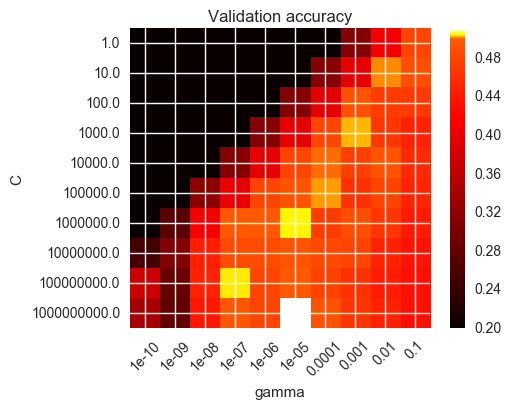

In [10]:
print('Heat map:')
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.3, right=0.8, bottom=0.3, top=0.8)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot, norm=MidpointNormalize(vmin=0.2, midpoint=0.5))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

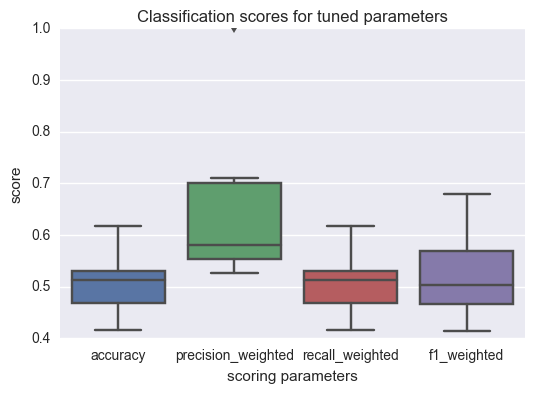

In [12]:
######### Estimation of final scores from this tuning:
scoring_param = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted' ]
scores = []

for scoring in scoring_param:
    SVM = make_pipeline(StandardScaler(), SVC(C=1000000, gamma=1.0e-05))
    cv=LeaveOneGroupOut().split(X, y, groups)
    validated = cross_val_score(SVM, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    scores.append(validated)
    
scores = np.array(scores)
scores = np.swapaxes(scores, 0, 1)
scores = pd.DataFrame(data=scores, columns=scoring_param)
    
sns.boxplot(data=scores)

plt.xlabel('scoring parameters')
plt.ylabel('score')
plt.title('Classification scores for tuned parameters')
plt.show()